# Chinese OCR

---

> This is the final project of CSE204 Machine Learning course in Ecole Polytechnique. We use CNN and EfficientNet model to do OCR for singular handwriting Chinese Characters. The project is mainly based on Tensorflow 2.0 API.

Making sure to install all the packages in the `requirements.txt` file, we can now start the process of OCRing the Chinese text.

## Contributors

---

- [Junyuan Wang](https://github.com/frank2002)
- [Yubo Cai](https://github.com/yubocai-poly)

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from alfred.utils.log import logger as logging
from tensorflow.keras.applications import EfficientNetB0
import pickle
import random

In [2]:
# load character mapping
this_dir = os.path.dirname(os.path.abspath("__file__"))

def load_characters():
    # a = open(os.path.join(this_dir, 'dataset\\characters.txt'), 'r').readlines() # If you are using Windows
    a = open(os.path.join(this_dir, 'dataset/characters.txt'), 'r').readlines() # If you are using Mac OS
    return [i.strip() for i in a]

all_characters = load_characters()
num_classes = len(all_characters)
print(f'There are {num_classes} classes of chinese characters in the dataset')
logging.info('all characters: {}'.format(num_classes))

18:10:37 05.30 INFO 1114677896.py:12]: all characters: 3755


There are 3755 classes of chinese characters in the dataset


## Load datasets

---

We want to load the dataset from the local file. The dataset is some `tfrecord` files which conotains images, labels, and resolution information for the images. The reason for saving as `tfrecord` format is to improve the training performance.

For more information about the dataset, please read the file `README.md` **Part 3. Dataset Preparation**. We also provide the converted dataset in the following link. You can directly use it for training.
- [test.tfrecord](https://drive.google.com/file/d/1knT-6pgkTKmvAp-fivCMUtOU9rRG_X-P/view?usp=sharing)
- [train.tfrecord](https://drive.google.com/file/d/1BhisIm3ebKTLasUx-VNGtIGXYEFJjtlc/view?usp=sharing)

In [3]:
# Necessary parameters
IMG_SIZE = 80 # This size is fixed for EfficientNetB0

In [73]:
# decode tfrecord to images and labels

def parse_image(record):
    """
    :param record: tfrecord file
    :return: image and label
    """
    features = tf.io.parse_single_example(record,
                                          features={
                                              'width':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'height':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'label':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'image':
                                                  tf.io.FixedLenFeature([], tf.string),
                                          })
    img = tf.io.decode_raw(features['image'], out_type=tf.uint8)
    w = features['width']
    h = features['height']
    img = tf.cast(tf.reshape(img, (w, h)), dtype=tf.float32)
    label = tf.cast(features['label'], tf.int64)
    return {'image': img, 'label': label}

def load_datasets(filename):
    """
    :param filename: tfrecord file
    :return: dataset
    """
    dataset = tf.data.TFRecordDataset([filename])
    dataset = dataset.map(parse_image)
    return dataset

### Explore datasets
In this part, we can see what are the datasets look like. 

In [5]:
train_ds = load_datasets('dataset/train.tfrecord') # read train.tfrecord
test_ds = load_datasets('dataset/test.tfrecord')

train_mapped = train_ds.shuffle(100).batch(32).repeat()
test_mapped = test_ds.batch(32).repeat()
train_mapped

<RepeatDataset element_spec={'image': TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

In [8]:
# summary inforamtion of the dataset, plot the width and height of the images
shapes_plot_train = [[], []]
shapes_plot_test = [[], []]
for i in train_ds:
    shapes_plot_train[0].append(i['image'].shape[0])
    shapes_plot_train[1].append(i['image'].shape[1])

for i in test_ds:
    shapes_plot_test[0].append(i['image'].shape[0])
    shapes_plot_test[1].append(i['image'].shape[1])

In [9]:
# show the number of pictures in the dataset
print(f'There are {len(shapes_plot_train[0])} pictures in the training dataset')
print(f'There are {len(shapes_plot_test[0])} pictures in the testing dataset')

There are 897758 pictures in the training dataset
There are 223991 pictures in the testing dataset


In [10]:
def plot_info_dataset(shapes_plot):
    # plot the histogram of the width and height of the images, and the third plot is the scatter plot
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].hist(shapes_plot[0], bins=100)
    ax[0].set_title('width')
    ax[0].set_xlabel('pixels')
    ax[0].set_ylabel('frequency')
    ax[1].hist(shapes_plot[1], bins=100)
    ax[1].set_title('height')
    ax[0].set_xlabel('pixels')
    ax[0].set_ylabel('frequency')
    ax[2].scatter(shapes_plot[0], shapes_plot[1])
    ax[2].set_title('width vs height')
    ax[2].set_xlabel('width (pixels)')
    ax[2].set_ylabel('height (pixels)')
    plt.show()

------------------- Information of training dataset -------------------


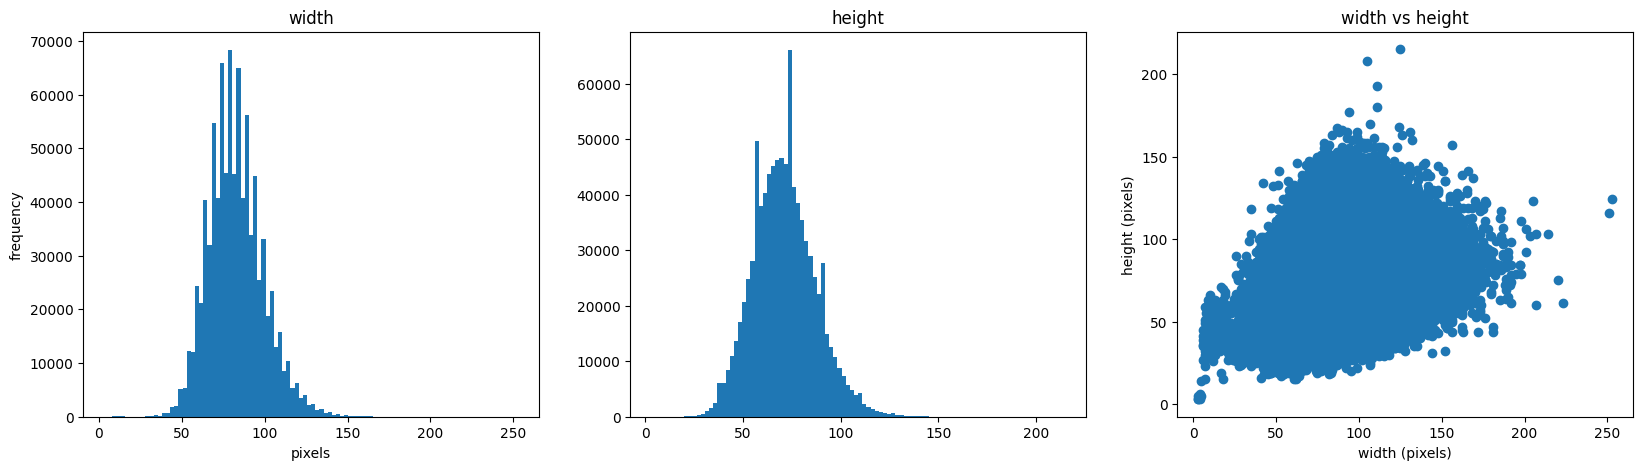

------------------- Information of testing dataset -------------------


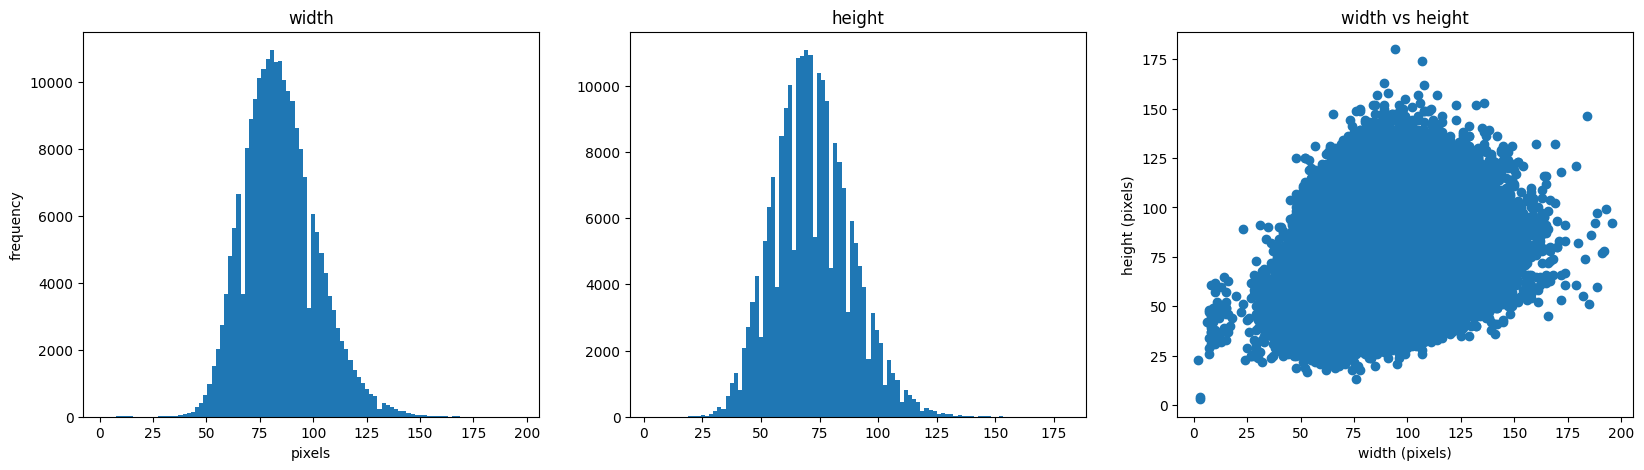

In [11]:
print('------------------- Information of training dataset -------------------')
plot_info_dataset(shapes_plot_train)
print('------------------- Information of testing dataset -------------------')
plot_info_dataset(shapes_plot_test)

We can also plot some images and labels from the datasets.

In [12]:
# default_font = FontProperties()
def plot_img(ds, characters, num =9):
    plt.rcParams["font.sans-serif"]=["SimHei"] #Set font to avoid garbled characters
    plt.rcParams["axes.unicode_minus"]=False # The same as above
    ax, fig = plt.subplots(3, 3, figsize=(12, 12))
    for i, data in enumerate(ds.take(num)):
        img = data['image'].numpy()
        label = data['label'].numpy()
        fig[i//3][i%3].imshow(img, cmap='gray')
        fig[i//3][i%3].set_title(f'label: {characters[label]}, size: {img.shape}', fontsize=15)
    
    plt.show()

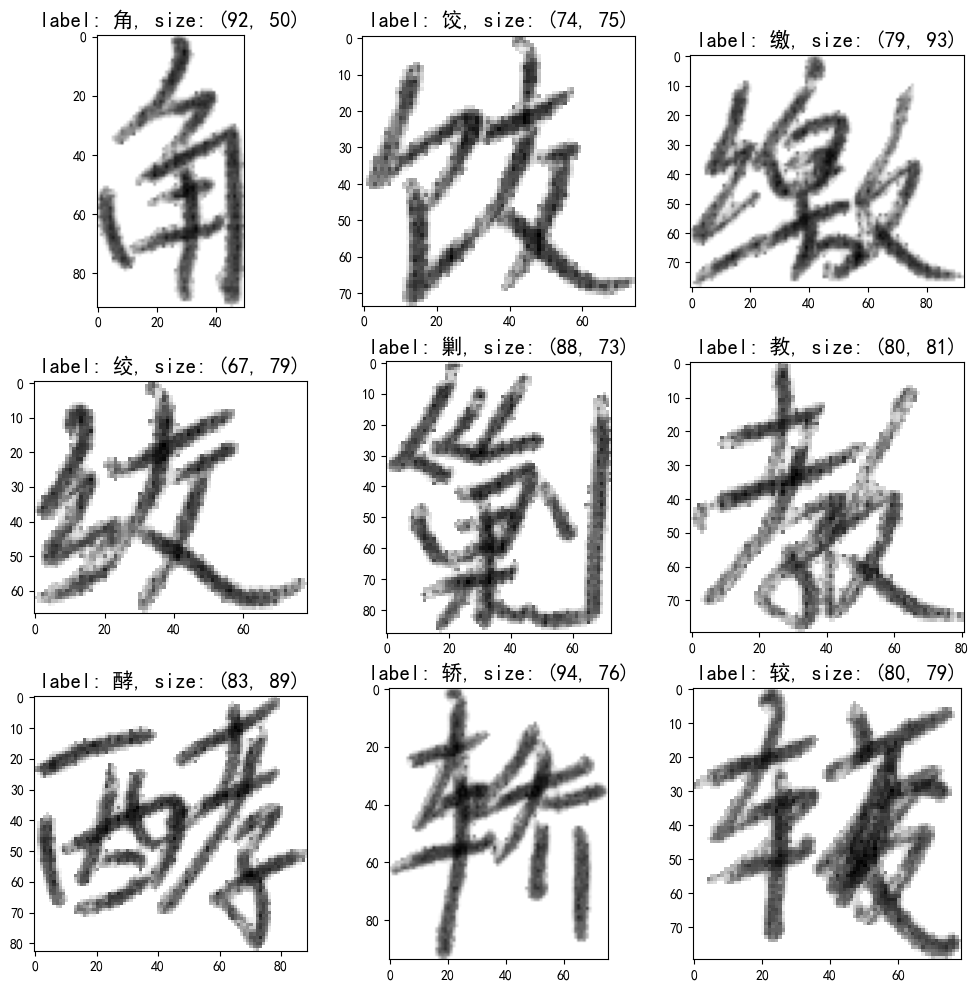

In [13]:
plot_img(train_ds, all_characters, num=9)

### Issue with the labels display in Mac OS

**Important, Please Read!!!** If you are using Mac OS, you may find that the labels are not displayed correctly. This is because the package `Matplotlib` is not compatible with `SimHei` font. To solve this problem, you can read this [MacOS Chinese Characters Label Problem](MacLabel_Problem.md).

## Training - With Simple CNN Model

---

In this part, we will define the models and training functions. <br>
In the `first` part, We will first start from a simple CNN model.

In [14]:
# some basic parameters
TARGET_SIZE = 64
IMG_SIZE = 224 # This size is fixed for EfficientNetB0
ckpt_path = './checkpoints/simple_net/cn_ocr-{epoch}.ckpt'
train_path = 'dataset/train.tfrecord'
test_path = 'dataset/test.tfrecord'

In [15]:
# image preprocessing
def preprocess(ds):
    """
    :param ds: dataset
    :return: image and label
    """
    ds['image'] = tf.expand_dims(ds['image'], axis=-1)
    ds['image'] = tf.image.resize(ds['image'], (TARGET_SIZE, TARGET_SIZE))
    ds['image'] = (ds['image'] - 128.) / 128.
    return ds['image'], ds['label']

In [16]:
# history log callback function
#
# This part is used to collecting the training statics and save them into a file.
#
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, history_path):
        super().__init__()
        self.history_path = history_path
        if os.path.exists(self.history_path):
            with open(self.history_path, 'rb') as f:
                self.history = pickle.load(f)
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key in logs:
            if key in self.history:
                self.history[key].append(logs[key])
            else:
                self.history[key] = [logs[key]]

    def on_train_end(self, logs=None):
        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history, f)

In [17]:
# Define a simple CNN model
def simple_net(input_shape, n_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), strides=(1, 1),
                      padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        layers.Flatten(),
        # layers.Dense(1024, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

# Define with a more complex CNN model - However, this model is not even converging
def CNN_ComplexModel_1(input_shape, n_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(input_shape=input_shape, filters=64, kernel_size=(3, 3), strides=(1, 1),
                      padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

In [18]:
# show the summary of the model
model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), len(all_characters))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 3755)              6

In [19]:
model_cnn_complex = CNN_ComplexModel_1((TARGET_SIZE, TARGET_SIZE, 1), len(all_characters))
model_cnn_complex.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 256)       

In this part. We will try to train the model.

In [20]:
def train_simple():
    print(f'number of classes: {num_classes}')

    history_path = 'history_simple.pickle'
    save_history_callback = SaveHistoryCallback(history_path)

    train_dataset = load_datasets(train_path)
    test_dataset = load_datasets(test_path)

    train_dataset = train_dataset.map(preprocess).shuffle(100).batch(32).repeat()
    test_dataset = test_dataset.shuffle(100).map(preprocess).batch(32)

    print(f'train dataset: {train_dataset}')

    # build model
    model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), num_classes)
    model.summary()

    # latest checkpoints
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(ckpt_path))
    if latest_ckpt:
        print(f'model resumed from: {latest_ckpt}')
        model.load_weights(latest_ckpt)
    else:
        print('training from scratch')
        
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_freq='epoch',
                                            save_best_only=True),
        save_history_callback
    ]
    try:
        model.fit(
            train_dataset,
            validation_data=test_dataset,
            validation_steps=1000,
            epochs=100,
            steps_per_epoch=1024,
            callbacks=callbacks)
    except KeyboardInterrupt:
        logging.info('keras model saved. KeyboardInterrupt')
        save_history_callback.on_train_end()
        return model 
    
    model.save_weights(ckpt_path.format(epoch=0))
    model.save(os.path.join(os.path.dirname(ckpt_path), 'cn_ocr_simple.h5'))
    logging.info('All epoch finished. keras model saved.')
    return model

From our trainning result, In the two CNN models we provide above, the simpler one has better performance. The more complex CNN model **not even converge** which is a quite interesting result.

In [21]:
# train the model (computation heavy)
model = train_simple()

number of classes: 3755
train dataset: <RepeatDataset element_spec=(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                               

18:20:18 05.30 INFO 3396354300.py:49]: keras model saved. KeyboardInterrupt


### Evaluaton and  Prediction visualization

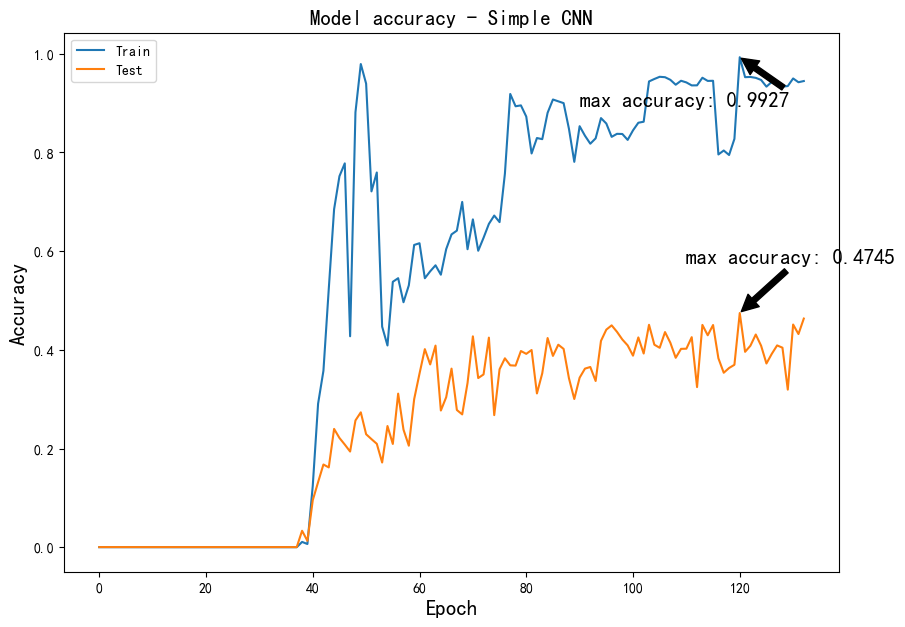

In [22]:
with open('history_simple.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.figure(figsize=(10, 7))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy - Simple CNN', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')

# show the highest accuracy in the graph
max_acc = max(history['val_accuracy'])
plt.annotate(f'max accuracy: {max_acc:.4f}', xy=(np.argmax(history['val_accuracy']), max_acc),
                xytext=(np.argmax(history['val_accuracy']) - 10, max_acc + 0.1),
                arrowprops=dict(facecolor='black', shrink=0.03), fontsize=15)
max_acc_train = max(history['accuracy'])
plt.annotate(f'max accuracy: {max_acc_train:.4f}', xy=(np.argmax(history['accuracy']), max_acc_train),
                xytext=(np.argmax(history['accuracy']) - 30, max_acc_train - 0.1),
                arrowprops=dict(facecolor='black', shrink=0.03), fontsize=15)
plt.show()

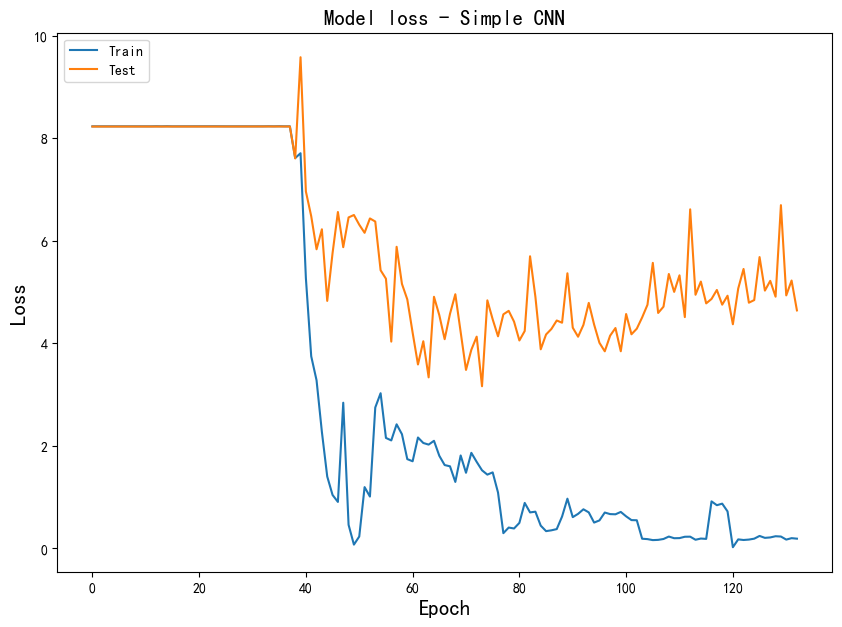

In [23]:
# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss - Simple CNN', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
# Load the best model
model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), num_classes)
model.load_weights(tf.train.latest_checkpoint(os.path.dirname(ckpt_path)))

In [25]:
# display the result
import random

def display_result(model, ds, characters):
    ds = ds.shuffle(100).map(preprocess).batch(32).repeat()
    f, axe = plt.subplots(3, 3, figsize=(15, 15))
    plt.rcParams["font.sans-serif"]=["SimHei"] #Set font to avoid garbled characters
    plt.rcParams["axes.unicode_minus"]=False # The same as above
    # take 9 samples
    for data in ds.take(1):
        images, labels = data
        predictions = model.predict(images)
        for i in range(9):
            axe[i//3, i%3].imshow(images[i].numpy().reshape(64, 64), cmap='gray')
            axe[i//3, i%3].axis('on')
            axe[i//3, i%3].set_title(f'pred: {characters[np.argmax(predictions[i])]}, label: {characters[labels[i]]}, Is Correct: {np.argmax(predictions[i]) == labels[i]}')
    plt.show()

1/1 [==============================] - 0s 65ms/step


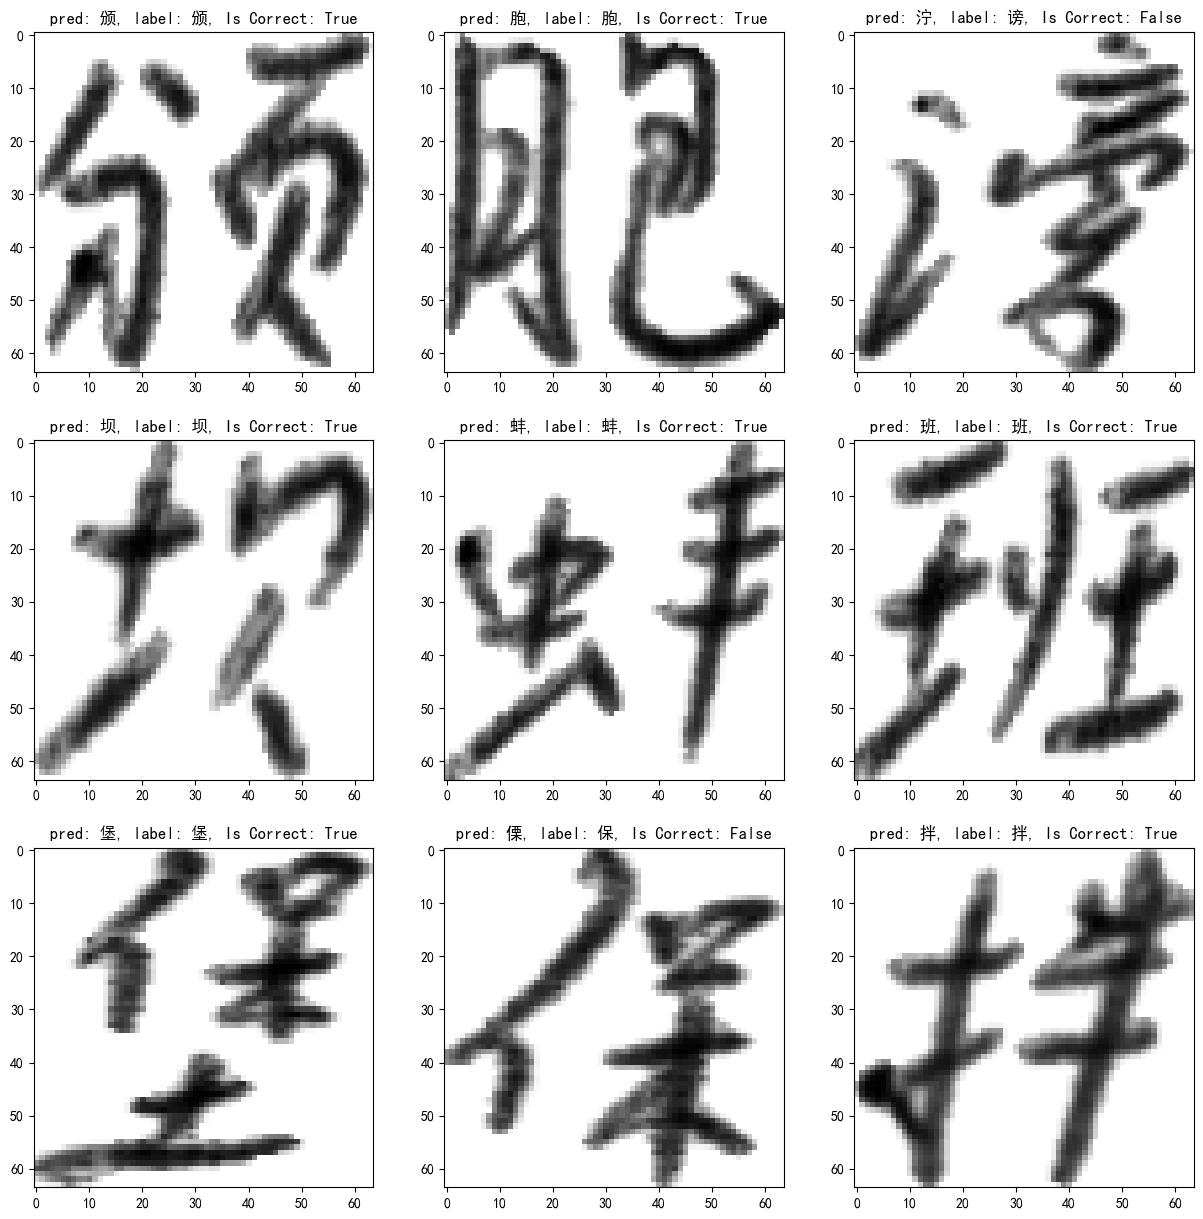

In [26]:
test_ds = load_datasets(test_path)
display_result(model, test_ds, all_characters)

## Refine the Model with EfficientNet

---

This model can only reach the `validation accuracy` to around `40%`, which is not satisfying for us. We decided to use a far more complicated model called `effcientnet` to train the model. This model is a state-of-the-art model for image classification. We will use the `B0` version of the model. For more information about the model, please read the [paper](https://arxiv.org/pdf/1905.11946.pdf) and this [webpage](https://www.kaggle.com/code/lys620/efficientnet-with-keras)

In [27]:
# some basic parameters
IMG_SIZE = 224 # This size is fixed for EfficientNetB0
ckpt_path = './checkpoints/efficient_net/cn_ocr-{epoch}.ckpt'
train_path = 'dataset/train.tfrecord'
test_path = 'dataset/test.tfrecord'

In [28]:
def preprocess_efficientnet(ds):
    """
    :param ds: dataset
    :return: image and label

    No normalization is needed here for EfficientNetB0
    """
    ds['image'] = tf.expand_dims(ds['image'], axis=-1)
    ds['image'] = tf.image.grayscale_to_rgb(ds['image'])
    ds['image'] = tf.image.resize(ds['image'], (IMG_SIZE, IMG_SIZE))
    return ds['image'], ds['label']

In [29]:
# model
def effcientnetB0_model():
    # EfficientNetB0 expects 3 channels
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(
        include_top=False, input_tensor=inputs, weights='imagenet')
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=x)
    return model

In [30]:
# model summary of EfficientNetB0
model = effcientnetB0_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [31]:
def train_efficientnet():
    print(f'number of classes: {num_classes}')

    history_path = 'history_efficientnet.pickle'
    save_history_callback = SaveHistoryCallback(history_path)

    train_dataset = load_datasets(train_path)
    test_dataset = load_datasets(test_path)

    train_dataset = train_dataset.map(preprocess_efficientnet).shuffle(100).batch(32).repeat()
    test_dataset = test_dataset.shuffle(100).map(preprocess_efficientnet).batch(32).repeat()

    print(f'train dataset: {train_dataset}')

    # build model
    model = effcientnetB0_model()
    # model.summary() # too long to display

    # latest checkpoints
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(ckpt_path))
    if latest_ckpt:
        print(f'model resumed from: {latest_ckpt}')
        model.load_weights(latest_ckpt)
    else:
        print('training from scratch')
        
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_freq='epoch',
                                            save_best_only=True),
        save_history_callback
    ]
    try:
        model.fit(
            train_dataset,
            validation_data=test_dataset,
            validation_steps=1000,
            epochs=100,
            steps_per_epoch=1024,
            callbacks=callbacks,
            use_multiprocessing=True)
    except KeyboardInterrupt:
        logging.info('keras model saved. KeyboardInterrupt')
        save_history_callback.on_train_end()
        return model 
    
    model.save_weights(ckpt_path.format(epoch=0))
    model.save(os.path.join(os.path.dirname(ckpt_path), 'cn_ocr_eff.h5'))
    logging.info('All epoch finished. keras model saved.')
    return model

In [38]:
# train the model (computation heavy)
model = train_efficientnet()

number of classes: 3755
train dataset: <RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
model resumed from: ./checkpoints/efficient_net\cn_ocr-1.ckpt
Epoch 1/100
1024/1024 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9972
Epoch 1: val_loss improved from inf to 0.54211, saving model to ./checkpoints/efficient_net\cn_ocr-1.ckpt
1024/1024 [==============================] - 163s 152ms/step - loss: 0.0130 - accuracy: 0.9972 - val_loss: 0.5421 - val_accuracy: 0.8860
Epoch 2/100
1024/1024 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9505
Epoch 2: val_loss did not improve from 0.54211
1024/1024 [==============================] - 155s 152ms/step - loss: 0.1858 - accuracy: 0.9505 - val_loss: 0.7122 - val_accuracy: 0.8370
Epoch 3/100
1024/1024 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9684
Epoch 3: val_loss did n

18:38:56 05.30 INFO 2887911528.py:50]: keras model saved. KeyboardInterrupt


### Evaluaton and  Prediction visualization

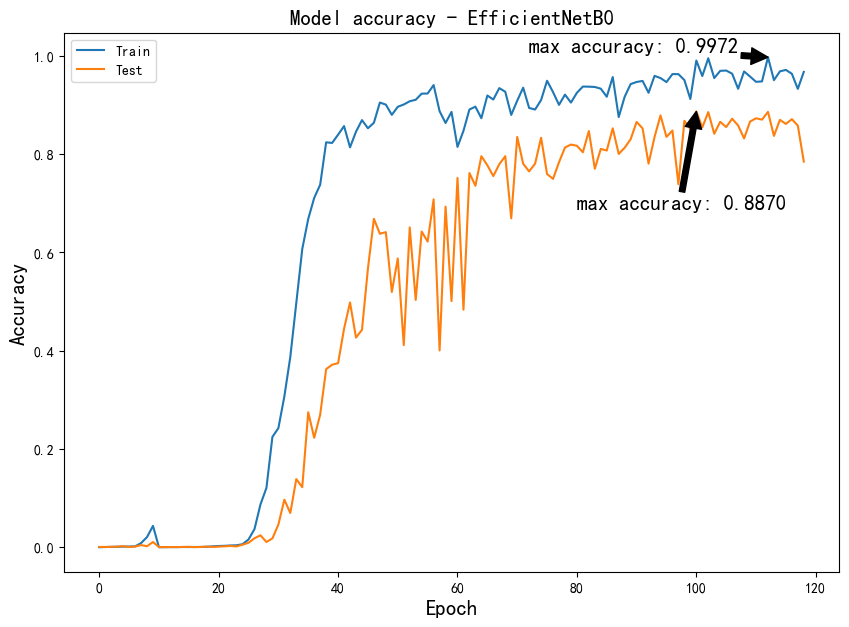

In [39]:
with open('history_efficientnet.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.figure(figsize=(10, 7))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy - EfficientNetB0', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')

# show the highest accuracy in the graph
max_acc = max(history['val_accuracy'])
plt.annotate(f'max accuracy: {max_acc:.4f}', xy=(np.argmax(history['val_accuracy']), max_acc),
                xytext=(np.argmax(history['val_accuracy']) - 20, max_acc - 0.2),
                arrowprops=dict(facecolor='black', shrink=0.001), fontsize=15)
max_acc_train = max(history['accuracy'])
plt.annotate(f'max accuracy: {max_acc_train:.4f}', xy=(np.argmax(history['accuracy']), max_acc_train),
                xytext=(np.argmax(history['accuracy']) - 40, max_acc_train + 0.01),
                arrowprops=dict(facecolor='black', shrink=0.001), fontsize=15)
plt.show()

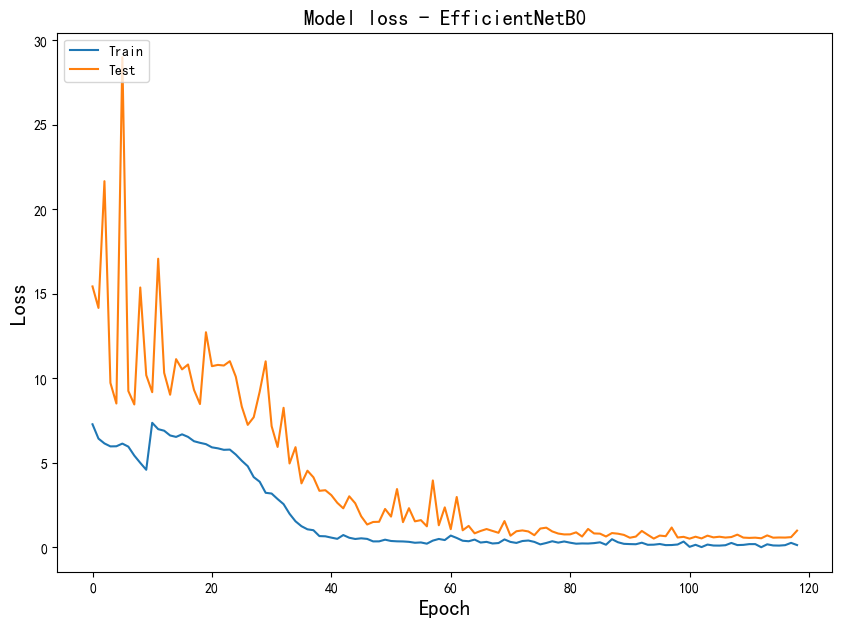

In [40]:
# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss - EfficientNetB0', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
# Load the best model
model = effcientnetB0_model()
model.load_weights(tf.train.latest_checkpoint(os.path.dirname(ckpt_path)))

In [42]:
def display_result(model, ds, characters):
    ds = ds.shuffle(100).map(preprocess_efficientnet).batch(32).repeat()
    _, axe = plt.subplots(3, 3, figsize=(15, 15))
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    for _, data in enumerate(ds.take(1)):
        images, labels = data
        predictions = model.predict(images)
        for i in range(9):
            axe[i//3, i%3].imshow(images[i].numpy().astype('uint8'), cmap='gray')
            axe[i//3, i%3].axis('on')
            axe[i//3, i%3].set_title(f'pred: {characters[np.argmax(predictions[i])]}, label: {characters[labels[i]]}, Is correct: {np.argmax(predictions[i]) == labels[i]}')
    plt.show()

1/1 [==============================] - 1s 949ms/step


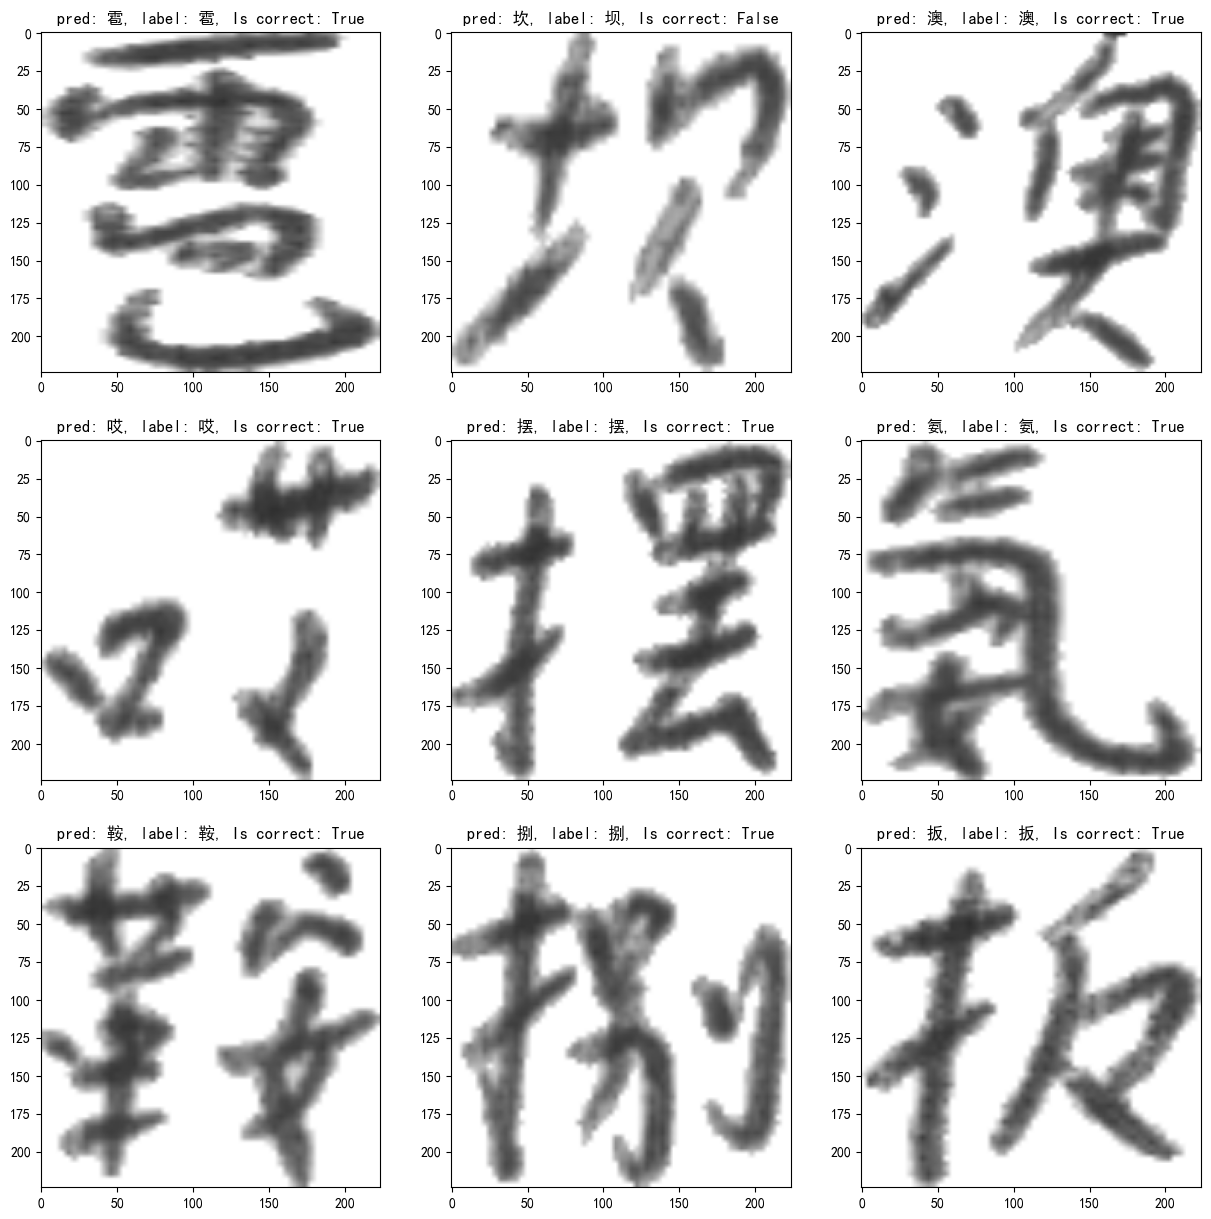

In [43]:
test_ds = load_datasets(test_path)
display_result(model, test_ds, all_characters)

We can see that for the model with `EfficientNet`, the `validation accuracy` can reach `85%` with about 80 epoches, which is a huge improvement compared with the simple CNN model.